In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from models.data.datasets import ImgFlowOccFromFolder
from models.networks.warping_layer import Warping

In [2]:
root = r'C:\Users\caodo\Desktop\TUM\Praktikum Visual Computing\project\ShapeNet\data'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
dset = ImgFlowOccFromFolder(transform=transform, root=root)
dataloader = DataLoader(dset, batch_size=1, shuffle=True)

In [14]:
imgs, flow, occ = next(iter(dataloader))
img1, img2 = imgs[:, 0, :, :], imgs[:, 1, :, :]

# warping
warping = Warping()
img_warped = warping(img2, flow)
img_occluded = (1 - occ) * img_warped 

In [15]:
img1 = img1.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
img2 = img2.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
occ = occ.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

img_warped = img_warped.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
img_occluded = img_occluded.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)


Text(0.5, 1.0, 'occluded image')

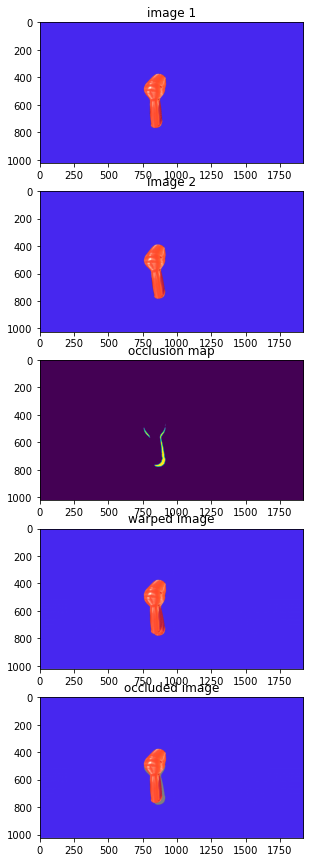

In [16]:
plt.figure(figsize=(12, 3 * 5))
plt.subplot(5, 1, 1)
plt.imshow(img1/2.0 + 0.5)
plt.title('image 1')

plt.subplot(5, 1, 2)
plt.imshow(img2/2.0 + 0.5)
plt.title('image 2')

plt.subplot(5, 1, 3)
plt.imshow(occ)
plt.title('occlusion map')

plt.subplot(5, 1, 4)
plt.imshow(img_warped/2.0 + 0.5)
plt.title('warped image')

plt.subplot(5, 1, 5)
plt.imshow(img_occluded/2.0 + 0.5)
plt.title('occluded image')